# Uniform Manifold Approximation and Projection

### Importation des modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize
from sklearn.manifold import SpectralEmbedding
from matplotlib import cm
import matplotlib.patches as mpatches

### Extraction du csv 

In [2]:
expr = pd.read_csv('MNIST.csv', sep=',')

y_train = expr.values[:,0] # Les Labels (pour les couleurs du plot)

X_train = expr.values[:,1:] # Les Coordonnées dans l'espace à 784 dimensions
X_train = np.log(X_train + 1)
n = X_train.shape[0] # Nombre d'échantillons

print("\nThis data set contains " + str(n) + " samples")
print("\nDimensions of the  data set: ")
print(X_train.shape)



This data set contains 999 samples

Dimensions of the  data set: 
(999, 784)


### Calcul de la matrice de distances euclidiennes

In [3]:
dist = np.square(euclidean_distances(X_train,X_train)) #Matrice des distances euclidiennes des échantillons
rho=[sorted(dist[i])[1] for i in range(len(dist))] #Pour chaque échantillon on prend le voisin le plus proche

## Partie A: Tsne

### Pour chaque point, calcul de la probabilité des autres points d'être dans le même cluster

In [4]:
def prob_high_dim(sigma, dist_row):
    """
    For each row of Euclidean distance matrix (dist_row) compute
    probability in high dimensions (1D array)
    """
    exp_distance = np.exp(-dist[dist_row] / (2*sigma**2))
    exp_distance[dist_row] = 0
    prob_not_symmetr = exp_distance / np.sum(exp_distance)
    #prob_symmetr = (prob_not_symmetr + prob_not_symmetr.T) / (2*n_samples)
    return prob_not_symmetr


### Mesure de la perplexité :  A quel point la distribution prédit l'échantillon
Perplexité : 2**Entropie (Entropie = Niveau de surprise, d'incertitude, d'information)

In [5]:
def perplexity(prob):
    """
    Compute perplexity (scalar) for each 1D array of high-dimensional probability
    """
    return np.power(2, -np.sum([p*np.log2(p) for p in prob if p!=0]))

### Optimisation de sigma pour une perplexité fixe 

Partie tricky : perp_of_sigma c'est une fonction, pas une variable 

perp_of_sigma -> la perplexité de la distribution de probabilités pour un sigma donné (peut être un peu naïf de l'écrire, mais on sait jamais)

In [6]:
def sigma_binary_search(perp_of_sigma, fixed_perplexity):
    """
    Solve equation perp_of_sigma(sigma) = fixed_perplexity 
    with respect to sigma by the binary search algorithm
    """
    sigma_lower_limit = 0
    sigma_upper_limit = 1000
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if perp_of_sigma(approx_sigma) < fixed_perplexity:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_perplexity - perp_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma

### Lancement du calcul

On obtient la liste des sigma qui maintiennent une perxplexité fixe entre les échantillons ainsi que les probabilités associés

In [11]:
PERPLEXITY = 30
prob = np.zeros((n,n))
sigma_array = []
for dist_row in range(n):
    func = lambda sigma: perplexity(prob_high_dim(sigma, dist_row))
    binary_search_result = sigma_binary_search(func, PERPLEXITY)
    prob[dist_row] = prob_high_dim(binary_search_result, dist_row)
    sigma_array.append(binary_search_result)
    if (dist_row + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(dist_row + 1, n))
print("\nMean sigma = " + str(np.mean(sigma_array)))

Sigma binary search finished 100 of 999 cells
Sigma binary search finished 200 of 999 cells
Sigma binary search finished 300 of 999 cells
Sigma binary search finished 400 of 999 cells
Sigma binary search finished 500 of 999 cells
Sigma binary search finished 600 of 999 cells
Sigma binary search finished 700 of 999 cells
Sigma binary search finished 800 of 999 cells
Sigma binary search finished 900 of 999 cells

Mean sigma = 11.036170256865752


### On s'assure la symmétrie en faisant la moyenne 

La symétrie n'est pas assurée car les sigmas d'un échantillon peuvent différer

In [12]:
P = prob + np.transpose(prob)
#P = (prob + np.transpose(prob)) / (2*n)
#P = P / np.sum(P)

In [13]:
def prob_low_dim(Y):
    """
    Compute matrix of probabilities q_ij in low-dimensional space
    """
    inv_distances = np.power(1 + np.square(euclidean_distances(Y, Y)), -1)
    np.fill_diagonal(inv_distances, 0.)
    return inv_distances / np.sum(inv_distances, axis = 1, keepdims = True)

In [14]:
def KL(P, Y):
    """
    Compute KL-divergence from matrix of high-dimensional probabilities 
    and coordinates of low-dimensional embeddings
    """
    Q = prob_low_dim(Y)
    return P * np.log(P + 0.01) - P * np.log(Q + 0.01)

In [15]:
def KL_gradient(P, Y):
    """
    Compute gradient of KL-divergence
    """
    Q = prob_low_dim(Y)
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + np.square(euclidean_distances(Y, Y)), -1)
    return 4*np.sum(np.expand_dims(P - Q, 2) * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

In [17]:
N_LOW_DIMS = 2
LEARNING_RATE = 0.6
MAX_ITER = 200

np.random.seed(12345)
y = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))
KL_array = []
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    y = y - LEARNING_RATE * KL_gradient(P, y)
    
    #plt.figure(figsize=(20,15))
    #plt.scatter(y[:,0], y[:,1], c=y_train.astype(int), cmap = 'tab10', s = 50)
    #plt.title("tSNE on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", fontsize = 20)
    #plt.xlabel("tSNE1", fontsize = 20); plt.ylabel("tSNE2", fontsize = 20)
    #plt.savefig('./Savefig/MNIST' + str(i) + '.png')
    #plt.close()
    
    KL_array.append(np.sum(KL(P, y)))
    if i % 10 == 0:
        print("KL divergence = " + str(np.sum(KL(P, y))))

Running Gradient Descent: 

KL divergence = 4136.208073016864
KL divergence = 3956.0935374639666
KL divergence = 3749.509200580424
KL divergence = 3596.161080517726
KL divergence = 3470.5552274581555
KL divergence = 3373.4024267693085
KL divergence = 3303.173547720635
KL divergence = 3254.549656870435
KL divergence = 3212.8969659308846
KL divergence = 3178.3804495268096
KL divergence = 3149.0243620936967
KL divergence = 3124.9130461172967
KL divergence = 3103.604253901403
KL divergence = 3087.1018871413125
KL divergence = 3070.7039339087014
KL divergence = 3054.460649200978
KL divergence = 3037.9392283771335
KL divergence = 3026.0859713525765
KL divergence = 3015.1552042218946
KL divergence = 3007.910395610757


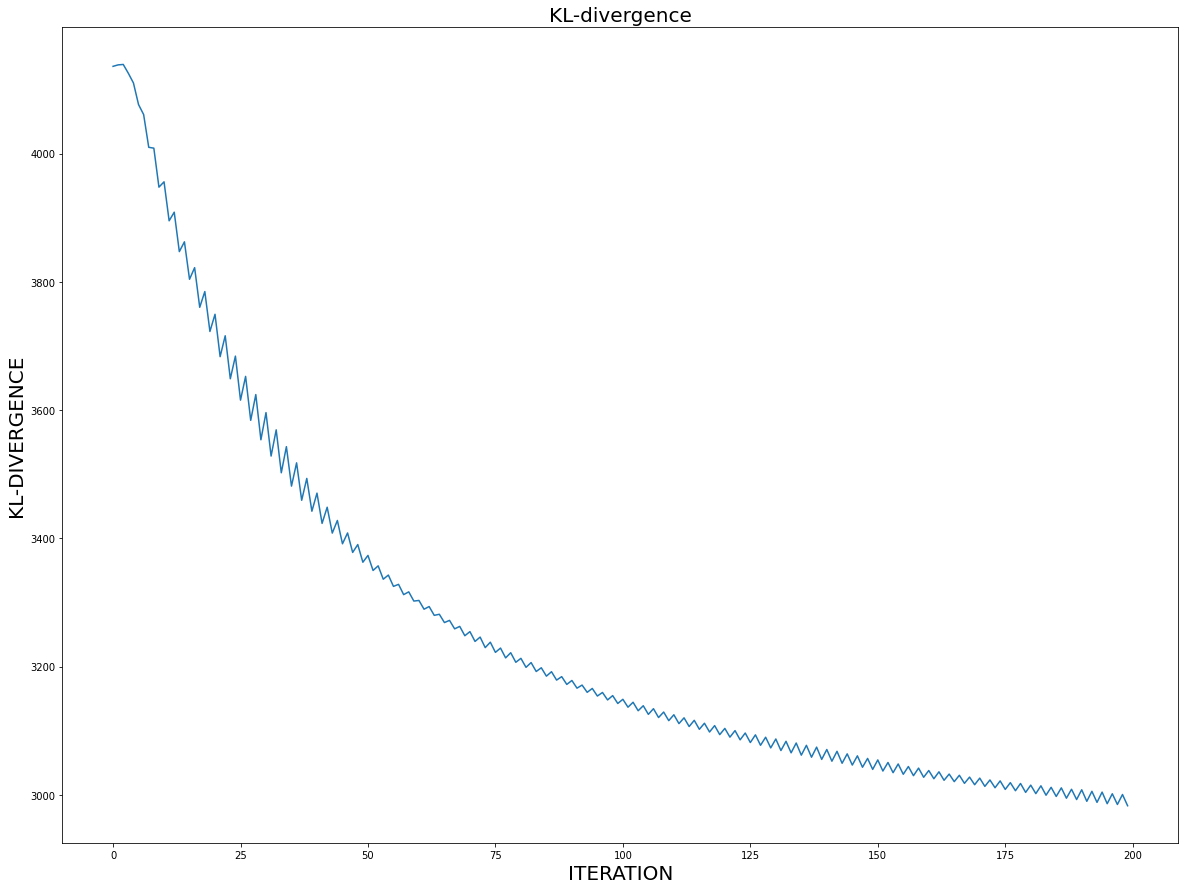

In [18]:
plt.figure(figsize=(20,15))
plt.plot(KL_array)
plt.title("KL-divergence", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("KL-DIVERGENCE", fontsize = 20)
plt.show()

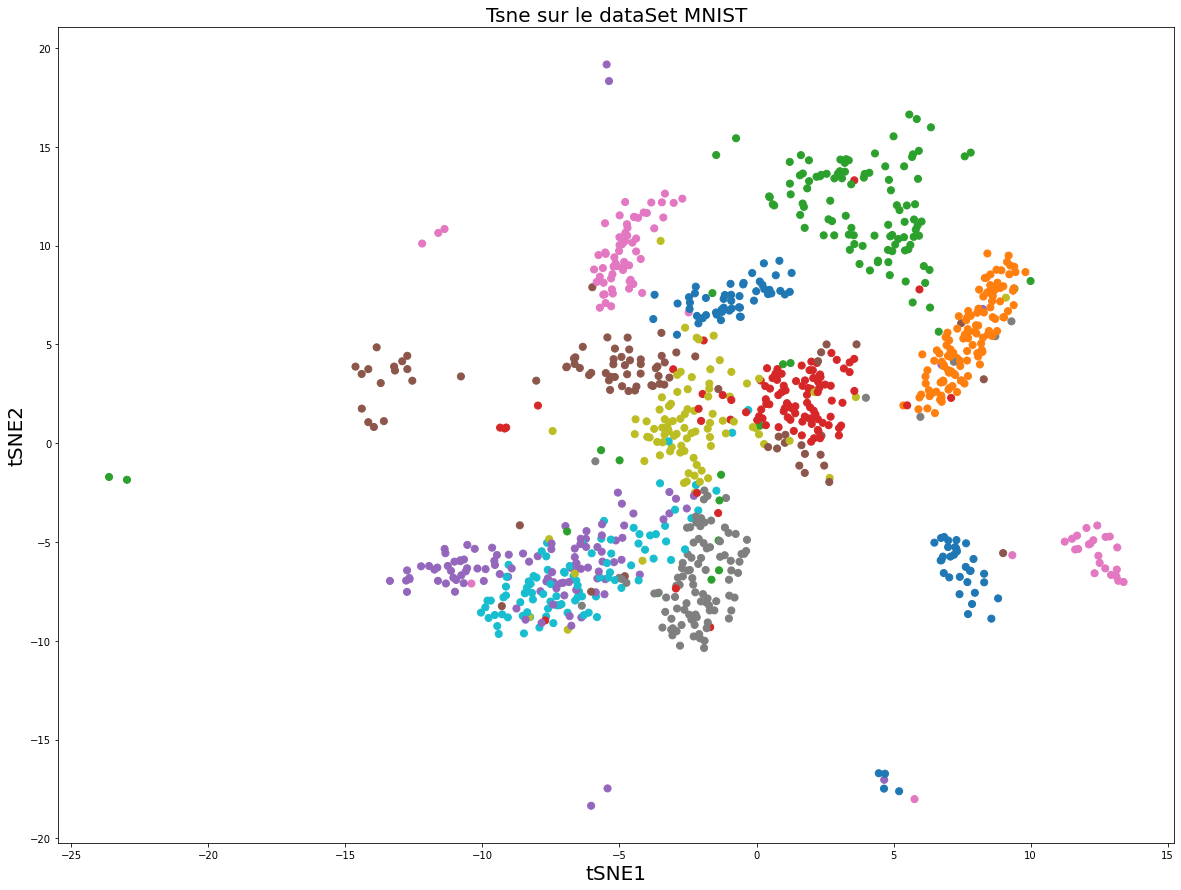

In [19]:
plt.figure(figsize=(20,15))
plt.scatter(y[:,0], y[:,1], c=y_train.astype(int), cmap = 'tab10', s = 50)
plt.title("Tsne sur le dataSet MNIST", fontsize = 20)
plt.xlabel("tSNE1", fontsize = 20); plt.ylabel("tSNE2", fontsize = 20)
plt.show()


## Partie B: UMAP

In [4]:
expr = pd.read_csv('MNIST.csv', sep=',')

y_train = expr.values[:,0] # Les Labels (pour les couleurs du plot)

X_train = expr.values[:,1:] # Les Coordonnées dans l'espace à 784 dimensions
X_train = np.log(X_train + 1)
n = X_train.shape[0] # Nombre d'échantillons

print("\nThis data set contains " + str(n) + " samples")
print("\nDimensions of the  data set: ")
print(X_train.shape)



This data set contains 999 samples

Dimensions of the  data set: 
(999, 784)


In [5]:
def prob_high_dim(sigma, dist_row):
    """
    For each row of Euclidean distance matrix (dist_row) compute
    probability in high dimensions (1D array)
    """
    d = dist[dist_row] - rho[dist_row]
    d[d < 0] = 0
    return np.exp(- d / sigma)


In [6]:
def k(prob):
    """
    Compute n_neighbor = k (scalar) for each 1D array of high-dimensional probability
    """
    return np.power(2, np.sum(prob))

In [7]:
def sigma_binary_search(k_of_sigma, fixed_k):
    """
    Solve equation k_of_sigma(sigma) = fixed_k 
    with respect to sigma by the binary search algorithm
    """
    sigma_lower_limit = 0
    sigma_upper_limit = 1000
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if k_of_sigma(approx_sigma) < fixed_k:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_k - k_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma


In [8]:
N_NEIGHBOR = 15
prob = np.zeros((n,n))
sigma_array = []
for dist_row in range(n):
    func = lambda sigma: k(prob_high_dim(sigma, dist_row))
    binary_search_result = sigma_binary_search(func, N_NEIGHBOR)
    prob[dist_row] = prob_high_dim(binary_search_result, dist_row)
    sigma_array.append(binary_search_result)
    if (dist_row + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(dist_row + 1, n))
print("\nMean sigma = " + str(np.mean(sigma_array)))

Sigma binary search finished 100 of 999 cells
Sigma binary search finished 200 of 999 cells
Sigma binary search finished 300 of 999 cells
Sigma binary search finished 400 of 999 cells
Sigma binary search finished 500 of 999 cells
Sigma binary search finished 600 of 999 cells
Sigma binary search finished 700 of 999 cells
Sigma binary search finished 800 of 999 cells
Sigma binary search finished 900 of 999 cells

Mean sigma = 184.27838983239832


In [15]:
#P = prob + np.transpose(prob) - np.multiply(prob, np.transpose(prob))
P = (prob + np.transpose(prob)) / 2

In [16]:
MIN_DIST = 0.25

x = np.linspace(0, 3, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

Hyperparameters a = 1.121436342246895 and b = 1.0574998767516528


In [17]:
a = 1.93
b = 0.8

In [18]:
def prob_low_dim(Y):
    """
    Compute matrix of probabilities q_ij in low-dimensional space
    """
    inv_distances = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    return inv_distances

In [19]:
def CE(P, Y):
    """
    Compute Cross-Entropy (CE) from matrix of high-dimensional probabilities 
    and coordinates of low-dimensional embeddings
    """
    Q = prob_low_dim(Y)
    return - P * np.log(Q + 0.01) - (1 - P) * np.log(1 - Q + 0.01)

def CE_gradient(P, Y):
    """
    Compute the gradient of Cross-Entropy (CE)
    """
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    Q = np.dot(1 - P, np.power(0.001 + np.square(euclidean_distances(Y, Y)), -1))
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q, axis = 1, keepdims = True)
    fact = np.expand_dims(a * P * (1e-8 + np.square(euclidean_distances(Y, Y)))**(b-1) - Q, 2)
    return 2 * b * np.sum(fact * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

In [20]:
N_LOW_DIMS = 2
LEARNING_RATE = 1
MAX_ITER = 200

np.random.seed(12345)
model = SpectralEmbedding(n_components = N_LOW_DIMS, n_neighbors = 50)
y = model.fit_transform(np.log(X_train + 1))
#y = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))

CE_array = []
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    y = y - LEARNING_RATE * CE_gradient(P, y)
    
    plt.figure(figsize=(20,15))
    plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 50)
    plt.title("UMAP on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", fontsize = 20)
    plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
    plt.savefig('./UMAP_iter_' + str(i) + '.png')
    plt.close()
    
    CE_current = np.sum(CE(P, y)) / 1e+5
    CE_array.append(CE_current)
    if i % 10 == 0:
        print("Cross-Entropy = " + str(CE_current) + " after " + str(i) + " iterations")

Running Gradient Descent: 

Cross-Entropy = 31.63017709458867 after 0 iterations
Cross-Entropy = 5.926912912303768 after 10 iterations
Cross-Entropy = 2.729870545255908 after 20 iterations
Cross-Entropy = 1.5448510222504894 after 30 iterations
Cross-Entropy = 1.139920419102562 after 40 iterations
Cross-Entropy = 0.978196814441754 after 50 iterations
Cross-Entropy = 0.8490715886818395 after 60 iterations
Cross-Entropy = 0.8420384255739765 after 70 iterations
Cross-Entropy = 0.8176621381559436 after 80 iterations
Cross-Entropy = 0.8057009114766279 after 90 iterations
Cross-Entropy = 0.8335276446214314 after 100 iterations
Cross-Entropy = 0.7694441114689977 after 110 iterations
Cross-Entropy = 0.7641929547419161 after 120 iterations
Cross-Entropy = 0.792471208031295 after 130 iterations
Cross-Entropy = 0.8641265872351442 after 140 iterations
Cross-Entropy = 0.8612953213338762 after 150 iterations
Cross-Entropy = 0.8756708984195292 after 160 iterations
Cross-Entropy = 0.8606835366257328 af

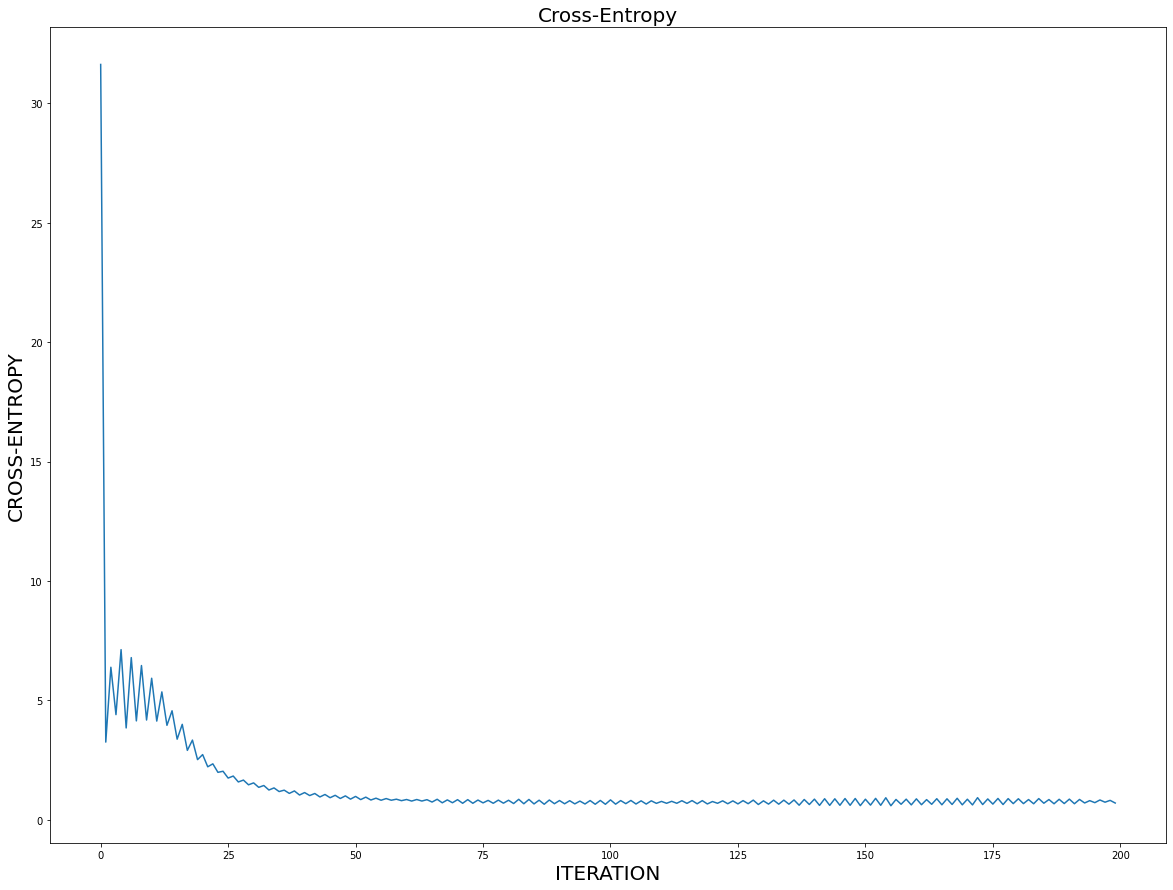

In [21]:
plt.figure(figsize=(20,15))
plt.plot(CE_array)
plt.title("Cross-Entropy", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("CROSS-ENTROPY", fontsize = 20)
plt.show()

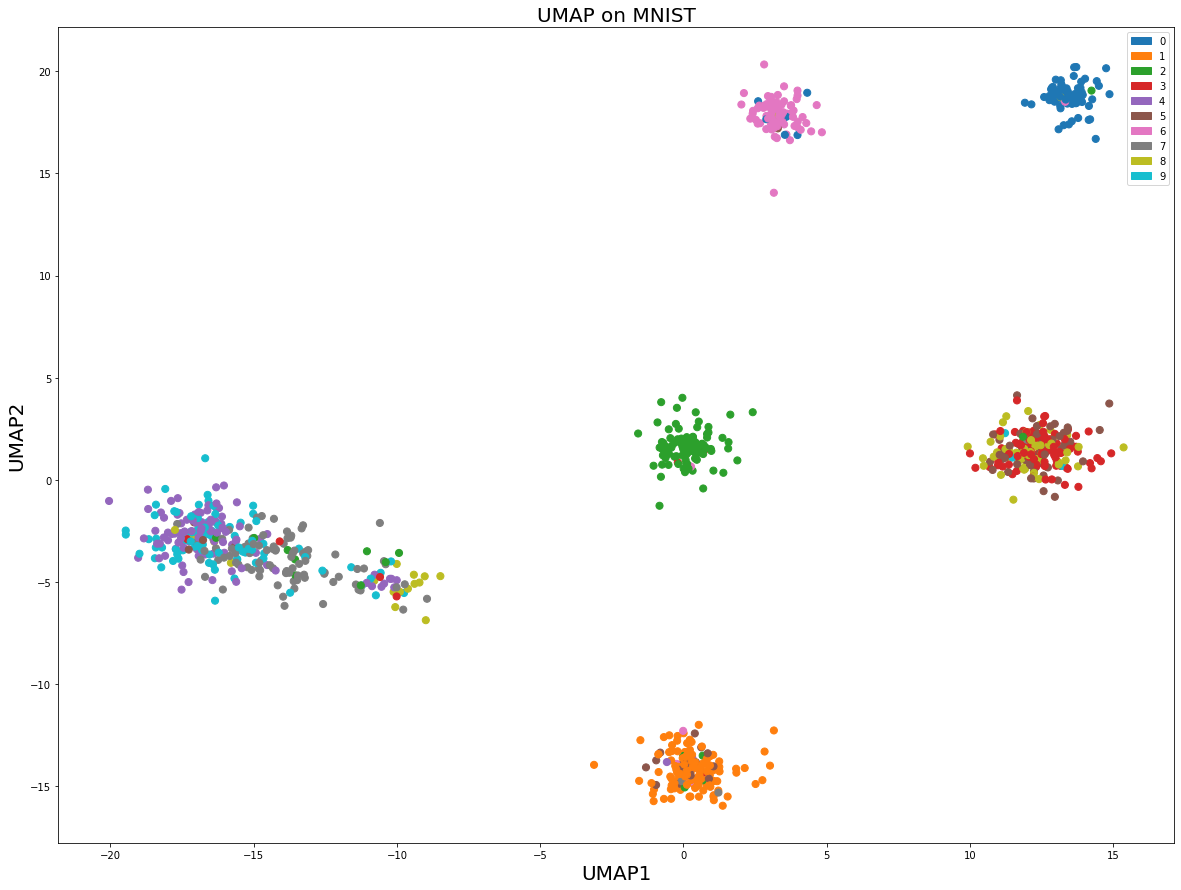

In [22]:
plt.figure(figsize=(20,15))
plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 50)
plt.title("UMAP on MNIST", fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)


cmap = cm.get_cmap('tab10', 10)
listePopulations=[]
for i in range(10):
    listePopulations.append(mpatches.Patch(color=cmap.colors[i], label=str(i)))
    
plt.legend(handles=listePopulations)
plt.show()